#### 뉴스 카테고리 분류 모델


[1] 데이터 불러오기 + 합치기<hr>

In [655]:
import pandas as pd
import re
import numpy as np

In [656]:
# 불필요한 컬럼 제외하고 가져오기
eduDF=pd.DataFrame()
envDF=pd.DataFrame()
foodDF=pd.DataFrame()
df_list=[eduDF, envDF, foodDF]
FILE_LIST=['./data/all_0.csv', './data/all_1.csv', './data/all_2.csv']


def make_kor(file, count):
    filterDF=pd.DataFrame()
    dataDF=pd.read_csv(file)         # 파일 읽기
    all=[]
    for text in dataDF['text']:
        a= re.sub('[^ㄱ-ㅎ가-힣]+',' ',text)         #한글만 남겨놓기
        all.append(a)
    filterDF['text']=all
    filterDF['label']=count
    return filterDF

In [756]:
edu=make_kor(r'C:\Users\KDP-25\Desktop\test\NLP\project\all_0.csv',0)
env=make_kor(r'C:\Users\KDP-25\Desktop\test\NLP\project\all_1.csv',1)
food=make_kor(r'C:\Users\KDP-25\Desktop\test\NLP\project\all_2.csv',2)

edu.info(), env.info(), food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1785 non-null   object
 1   label   1785 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 28.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1723 non-null   object
 1   label   1723 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1771 entries, 0 to 1770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1771 non-null   object
 1   label   1771 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.8+ KB


(None, None, None)

In [757]:
newsDF=pd.concat([edu, env, food])
newsDF['label'].value_counts()

label
0    1785
2    1771
1    1723
Name: count, dtype: int64

[2] 데이터 토큰화 및 불용어 제거 후 단어사전 생성<hr>

In [758]:
from konlpy.tag import Okt
from collections import Counter
from NLPfunc import *

In [759]:
len(newsDF)

5279

In [760]:
from sklearn.model_selection import train_test_split

In [761]:
# 학습, 테스트 분리 후 DS
newsDF=newsDF.reset_index(drop=True)
trainDF=newsDF.sample(frac=0.9, random_state=100)
testDF=newsDF.drop(trainDF.index)
print(trainDF.index)


# 토큰화 인스턴스
okt=Okt()

Index([1639, 4204, 3264,  664, 1039,  640, 3765, 2047, 1575,  995,
       ...
       5102, 3799, 2791,  745, 2544, 3981, 4447, 2177, 3110, 3035],
      dtype='int64', length=4751)


In [762]:
trainDF.index

Index([1639, 4204, 3264,  664, 1039,  640, 3765, 2047, 1575,  995,
       ...
       5102, 3799, 2791,  745, 2544, 3981, 4447, 2177, 3110, 3035],
      dtype='int64', length=4751)

In [763]:
testDF['label'].value_counts(), trainDF['label'].value_counts()

(label
 1    182
 0    174
 2    172
 Name: count, dtype: int64,
 label
 0    1611
 2    1599
 1    1541
 Name: count, dtype: int64)

In [764]:
## 불용어 리스트 불러오는 함수
STOP_PATH = 'kor_stopwords.txt'

def make_stopwords(STOP_PATH):
    with open(STOP_PATH, 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines() # 문장단위로
    return set(stopwords)  

stopwords = make_stopwords(STOP_PATH)

In [765]:
# 토큰화를 통한 단어사전 생성 ->Counter와 리스트 컴프리헨션을 통해
# - 행마다 데이터를 추출하여 토큰 반환 및 Counter에 저장
def make_vocab(data, tag, stopwords, vocab_num):
    '''
    데이터를 통해 단어사전을 만드는 함수 \n
    DF 데이터 분리했을 경우 인덱스 초기화하기!\n
    단어사전 반환\n
    params: 데이터프레임
    '''
    token_list=[]
    counter=Counter()
    for text in data:
        # 한글빼고 다지우기
        # text=re.sub('[^ㄱ-ㅎ가-힣]+',' ',text)
        # 형태소 분석 (stem-> 어근으로 통일, norm-> 정규화)
        tokens=tag.morphs(text)
        token_list.append(tokens)
        #불용어, 구두점, 특수문자 제거

    # 형태소 단어 counter에 저장
    for t in token_list:
        for token in t:
            print(token)
            if token in stopwords:
                t.remove
            for s in stopwords:
                if t == s:  #불용어 제거
                    t.remove(token)
        counter.update(t)
    # 빈도순으로 임의의 수만큼 추출
    
    # 단어 사전에 저장
    vocab={'<PAD>':0, '<UNK>':1}
    vocab_list=[]
    for token, cnt in counter.most_common(vocab_num):
        if token in stopwords:
            pass
        else: vocab_list.append(token)
    vocab.update({word: i+2 for i, word in enumerate(vocab_list)})
    return vocab

In [ ]:
# 토큰화 및 단어사전 생성
train_vocab= make_vocab(data=trainDF['text'], tag=okt, stopwords=stopwords, vocab_num=10000)
# test_vocab= make_vocab(data=testDF['text'], tag=okt, stopwords=stopwords, vocab_num=10000)

print(len(train_vocab))

In [732]:
t_vocab=train_vocab.copy()
for key, v in t_vocab.items():
    if key in stopwords:
        a= train_vocab.pop(key)

In [733]:
train_vocab.items()

dict_items([('<PAD>', 0), ('<UNK>', 1), ('할', 2), ('서울', 3), ('명', 4), ('지역', 5), ('의료', 6), ('기자', 7), ('대학', 8), ('교육', 9), ('한다', 10), ('제공', 11), ('지원', 12), ('학생', 13), ('병원', 14), ('전', 15), ('사업', 16), ('학교', 17), ('정부', 18), ('연합뉴스', 19), ('원', 20), ('위', 21), ('의대', 22), ('시', 23), ('며', 24), ('밝혔다', 25), ('지난해', 26), ('됐다', 27), ('사진', 28), ('장', 29), ('통해', 30), ('성', 31), ('뉴스', 32), ('확대', 33), ('정책', 34), ('올해', 35), ('환경', 36), ('대한', 37), ('계획', 38), ('운영', 39), ('비', 40), ('환자', 41), ('관리', 42), ('지난', 43), ('학년', 44), ('오후', 45), ('강원', 46), ('교수', 47), ('정원', 48), ('연', 49), ('회', 50), ('발표', 51), ('교육청', 52), ('발생', 53), ('교육부', 54), ('교사', 55), ('한국', 56), ('관련', 57), ('경우', 58), ('서', 59), ('의사', 60), ('전국', 61), ('결과', 62), ('날', 63), ('금지', 64), ('보다', 65), ('추진', 66), ('치료', 67), ('전공', 68), ('센터', 69), ('지', 70), ('뉴시스', 71), ('대상', 72), ('하기', 73), ('되는', 74), ('대표', 75), ('기온', 76), ('사회', 77), ('따르면', 78), ('해야', 79), ('진행', 80), ('더', 81), ('눈', 82), ('부산'

In [734]:
def vectorize(vocab, DF, tokenizer):
    '''
    단어사전을 통해 문장을 수치화하는 함수

    '''
    vector_list=[]
    vecDF=DF.copy()
    for t in DF['text']:
        token_lists=tokenizer.morphs(t)
        vector_token=[vocab[token] if token in vocab else vocab['<UNK>'] for token in token_lists]
        vector_list.append(vector_token)
    vecDF['text']=vector_list

    return vecDF

In [735]:
# 문장 벡터화
trainVec=vectorize(vocab=train_vocab, DF=trainDF, tokenizer=okt)
testVec=vectorize(vocab=train_vocab, DF=testDF, tokenizer=okt)

In [736]:
trainVec['text'][0]

[1391,
 54,
 1,
 1,
 8,
 1,
 480,
 320,
 1,
 1307,
 1,
 1,
 4255,
 1,
 136,
 1724,
 374,
 320,
 464,
 429,
 1692,
 5924,
 252,
 1,
 290,
 1,
 1,
 126,
 141,
 295,
 118,
 675,
 1,
 8,
 320,
 1,
 1,
 1,
 970,
 779,
 351,
 2683,
 1,
 8811,
 1,
 5,
 8,
 1,
 1,
 320,
 464,
 1,
 1,
 824,
 815,
 1,
 1,
 5,
 8,
 1,
 1,
 1,
 378,
 1,
 2196,
 1,
 7,
 1,
 1,
 7,
 54,
 1,
 1724,
 1,
 1,
 8,
 320,
 464,
 429,
 1692,
 5924,
 1,
 1,
 65,
 9007,
 252,
 1,
 436,
 290,
 1,
 1,
 126,
 141,
 1,
 2457,
 516,
 1,
 320,
 464,
 855,
 1,
 7054,
 2072,
 13,
 132,
 1471,
 1,
 351,
 1847,
 1,
 1,
 991,
 1,
 2167,
 8,
 1,
 1,
 320,
 1,
 4255,
 6499,
 1,
 1,
 5,
 8,
 110,
 353,
 351,
 1,
 1,
 2683,
 1,
 1,
 1,
 1,
 13,
 787,
 2322,
 291,
 1,
 931,
 757,
 1,
 1,
 39,
 2369,
 489,
 368,
 224,
 9733,
 1,
 1,
 197,
 18,
 1,
 1,
 109,
 9734,
 4728,
 261,
 9255,
 1,
 320,
 1,
 923,
 3709,
 1,
 205,
 8,
 1,
 1,
 493,
 374,
 1,
 1152,
 2112,
 702,
 413,
 1,
 299,
 20,
 4977,
 1,
 4728,
 261,
 827,
 1,
 1,
 380,
 1,
 8,
 1,

In [737]:
# 패딩
def padding(length, textList):
    pad_texts=[]
    for text in textList:
            # 선택 길이> 문장길이 일때
        if length>len(text):
                                            # 남은 텍스트 길이만큼 0으로 채우기
            text=text+[0]*(length-len(text))
        else: # 선택 길이< 문장 길이 일때
            text=text[:length]              # 선택 길이만큼 슬라이싱
        pad_texts.append(text)
    return pad_texts

In [738]:
train_pad=padding(length=200, textList=trainVec['text'])
trainPad=trainVec.copy()
trainPad['text']=train_pad
test_pad= padding(length=200, textList=testVec['text'])
testPad=testVec.copy()
testPad['text']=test_pad

In [739]:
testPad['label'].value_counts()

label
1    149
0    135
2    131
Name: count, dtype: int64

[3] 모델 설계 및 훈련 진행<hr>
- 라벨: 3개 (분류)
- 알고리즘: rnn/ lstm
- 0:교육, 1:환경, 2:의료/식품

In [740]:
# 데이터셋, 데이터로더 생성
import torch

train_tensor=torch.tensor(train_pad)
train_label= torch.FloatTensor(trainVec['label'].values)

test_tensor=torch.tensor(test_pad)
test_label= torch.FloatTensor(testVec['label'].values)

trainDS=TextDataset(train_tensor, train_label)
testDS= TextDataset(test_tensor, test_label)

trainDL=DataLoader(trainDS, batch_size=32)
testDL=DataLoader(testDS, batch_size=32)


In [741]:
import torch.nn as nn
from typing import Literal

# 커스텀 모델 생성
class textCLF(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers,
                 model_type: Literal['lstm', 'rnn'], dropout=0.5, bidirectional=True):
        super().__init__()

        # 임베딩 층
        # num-> 단어사전의 크기
        self.embedding= nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        if model_type =='rnn':
            self.model=nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True
            )
        elif model_type =='lstm':
            self.model= nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True
            )
        # 양방향 여부
        if bidirectional:
            self.classifier= nn.Linear(hidden_dim*2, 3)
        else:
            self.classifier= nn.Linear(hidden_dim, 3)
        self.dropout=nn.Dropout(dropout)

    #포워딩
    def forward(self, input):
        embeddings= self.embedding(input)
        output,_= self.model(embeddings)
        last_output=output[:,-1,:]
        last_output=self.dropout(last_output)
        logits=self.classifier(last_output)
        return logits

In [742]:
from torch import optim
# 파라미터 설정

n_vocab= len(train_vocab)
hidden_dim= 64
embedding_dim= 128
n_layers= 2

device= 'cuda' if torch.cuda.is_available() else 'cpu'
classifier= textCLF(
    n_vocab=n_vocab, hidden_dim=hidden_dim, 
    embedding_dim=embedding_dim, n_layers=n_layers, model_type='lstm'
).to(device)
criterion= nn.CrossEntropyLoss()

optimizer= optim.Adam(classifier.parameters(), lr=1)

SAVE_PATH='./model'
SAVE_FILE='newsclf_all.pth'


In [743]:
for f, t in trainDL:
    print(f.shape)
    break

torch.Size([32, 200])


In [744]:
from get_model import Custom_model
from torchmetrics.classification import F1Score, MulticlassF1Score, Accuracy
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.regression import R2Score, MeanSquaredError
import torch
import matplotlib.pyplot as plt
from typing import Literal
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler

def model_training(model, trainDL, testDL, optimizer, epoch: int, LIMIT: int, break_param: Literal['score', 'loss'],
                   type: Literal['reg', 'binary', 'muticlass'],optim_type: Literal['score', 'loss'], SAVE_PATH, SAVE_FILE,
                   save_type: Literal['all', 'param', 'None'], numcls: int):
    '''
    학습진행+ 모니터링+ 최적의 결과 저장
    type= 'reg'|'binary'|'mclf'
    return: LOSS_HISTORY, SCORE_HISTORY
    '''
    scheduler= lr_scheduler.ReduceLROnPlateau(optimizer, patience=LIMIT, mode='max')
    EPOCH=epoch
    # 손실, 평가값 저장
    LOSS_HISTORY, SCORE_HISTORY= [[],[]], [[],[]]
    for ep in range(EPOCH):
        print(f'{ep+1}/{EPOCH}')
        model.train()
        loss_total, score_total= 0,0
        loss_val_total, score_val_total=0,0

        for train_feature, train_target in trainDL:
            # 학습
            # train_feature=torch.tensor(train_feature, dtype=torch.float32)
            pre_y=model(train_feature)

            # 손실
            if type=='reg':
                Lossfunc=MeanSquaredError()
                Scorefunc=R2Score()
            elif type=='binary':
                Lossfunc= nn.BCELoss()
                Scorefunc=F1Score(task='binary', num_classes=numcls)
            elif type=='muticlass':
                Lossfunc=nn.CrossEntropyLoss()
                Scorefunc=Accuracy(task='multiclass', num_classes=3)
                # Scorefunc=F1Score(task='multiclass', num_classes=numcls)
            loss= Lossfunc(pre_y, train_target.reshape(-1).long())
        
            loss_total+=loss.item()

            # 평가
            score= Scorefunc(pre_y, train_target.reshape(-1).long())
            score_total+=score.item()

            # 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증

        model.eval()
        with torch.no_grad():
            for val_feature, val_target in testDL:
                # 학습

                pre_val= model(val_feature)

                # 손실
                loss= Lossfunc(pre_val, val_target.reshape(-1).long() if type=='muticlass' else val_target if type=='reg' else val_target)
                loss_val_total+=loss.item()

                # 평가
                score= Scorefunc(pre_val, val_target.reshape(-1) if type=='muticlass' else val_target)
                score_val_total+=score.item()

        
        # 저장
        LOSS_HISTORY[0].append(loss_total/len(trainDL))
        SCORE_HISTORY[0].append(score_total/len(trainDL))
        print(f'Train\n Loss: {loss_total/len(trainDL)}\n Score: {score_total/len(trainDL)}')

        LOSS_HISTORY[1].append(loss_val_total/len(testDL))
        SCORE_HISTORY[1].append(score_val_total/len(testDL))
        print(f'Val\n Loss: {loss_val_total/len(testDL)}\n Score: {score_val_total/len(testDL)}')

        # 성능이 좋은 학습 가중치 저장
        if save_type:
            if save_type=='all':
                save_type= model
            elif save_type=='param':
                save_type=model.state_dict()
            if len(SCORE_HISTORY[1]) == 1: 
            #첫번째는 무조건 저장
                torch.save(save_type, SAVE_PATH+SAVE_FILE)  
                
            else:
                if SCORE_HISTORY[1][-1]> max(SCORE_HISTORY[1][:-1]): # 자신을 제외한 최대점수값과 비교
                    torch.save(save_type, SAVE_PATH+str(ep)+SAVE_FILE) 
                     
        else: pass

        
        # 학습 진행 모니터링 (검증 데이터 개선이 되지 않았을때 누적 ->  평가, 손실 중 지표 하나 선택)
        # 최적화 스케쥴러 인스턴스 업데이트
        scheduler.step(score_val_total/len(testDL))

        # 손실 감소 (또는 성능 개선)이 안되는 경우 조기종료
        if scheduler.num_bad_epochs== scheduler.patience:
            print(f'{scheduler.patience} EPOCH 성능 개선이 없어서 조기종료함')
            break

    return LOSS_HISTORY, SCORE_HISTORY

In [745]:
import pickle

In [746]:
LOSS_HISTORY, SCORE_HISTORY= model_training(model= classifier, trainDL=trainDL,
                                            testDL=testDL, optimizer=optimizer,
                                            epoch=50, LIMIT=5, SAVE_PATH=SAVE_PATH,
                                            SAVE_FILE=SAVE_FILE, numcls=3,
                                            break_param='score', save_type='all',
                                            type='muticlass', optim_type='score')


1/50
Train
 Loss: nan
 Score: 0.34030745490493935
Val
 Loss: nan
 Score: 0.3245192307692308
2/50
Train
 Loss: nan
 Score: 0.3464506172981018
Val
 Loss: nan
 Score: 0.3245192307692308
3/50
Train
 Loss: nan
 Score: 0.3464506172981018
Val
 Loss: nan
 Score: 0.3245192307692308
4/50
Train
 Loss: nan
 Score: 0.3464506172981018
Val
 Loss: nan
 Score: 0.3245192307692308
5/50
Train
 Loss: nan
 Score: 0.3464506172981018
Val
 Loss: nan
 Score: 0.3245192307692308
6/50
Train
 Loss: nan
 Score: 0.3464506172981018
Val
 Loss: nan
 Score: 0.3245192307692308
5 EPOCH 성능 개선이 없어서 조기종료함


In [747]:
with open('vocab.pikle', mode='wb') as f:
    pickle.dump(train_vocab, f)

#max=66

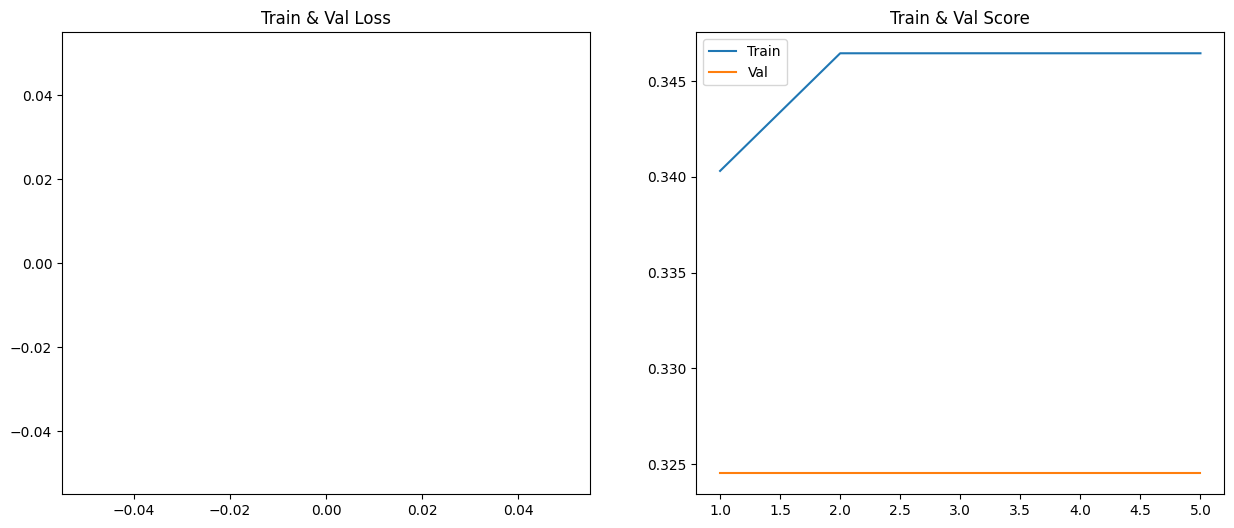

In [748]:
from get_train_model import draw_result
draw_result(EPOCH=5, LOSS_HISTORY=LOSS_HISTORY, SCORE_HISTORY=SCORE_HISTORY)

In [749]:
def vectorize2(vocab, DF, tokenizer):
    '''
    단어사전을 통해 문장을 수치화하는 함수

    '''
    vector_list=[]
  
    for t in DF:
        token_lists=tokenizer.morphs(t)
        vector_token=[vocab[token] if token in vocab else vocab['<UNK>'] for token in token_lists]
        vector_list.extend(vector_token)

    return vector_list

In [750]:
# 패딩
def padding2(length, text):
    pad_texts=[]
    # for text in textList:
    #         # 선택 길이> 문장길이 일때
    if length>len(text):
                                        # 남은 텍스트 길이만큼 0으로 채우기
        text=text+[0]*(length-len(text))
    else: # 선택 길이< 문장 길이 일때
        text=text[:length]              # 선택 길이만큼 슬라이싱
    pad_texts.append(text)
    return pad_texts

In [751]:
def predict_mcf2(model, data, result):
    dataTS=data.reshape(1,-1) #torch.FloatTensor(data).reshape(1,-1)
    pre_val=model(dataTS)
    pre_val=F.softmax(pre_val, dim=1)
    print(f'{result[0]}: {max(pre_val[0].detach()):.4f}')
    return f'{result[0]}: {max(pre_val[0].detach()):.4f}'

In [752]:
# 검증
PATH='./model8newsclf_all.pth'
text='[제주=뉴시스] 양영전 기자 = 제주도교육청은 오는 12~13일 협재해수욕장과 표선해수욕장에서 2024년 제주바다쓰레기저감실천 캠페인 우리 처음 만난 바다처럼을 운영한다고 11일 밝혔다.'
test_model= torch.load(PATH)
from predict import *
# 한글만 남기고 모두 제거
a= re.sub('[^ㄱ-ㅎ가-힣]+',' ',text)
tokenizer=Okt()
# 토큰화
token_text=tokenizer.morphs(a)

#단어사전을 통한 벡터화
# 단어사전 불러오기
with open('vocab.pikle', 'rb') as f:
    test_vocab=pickle.load(f)
# 벡터화
vec_token= vectorize2(vocab=test_vocab, DF=token_text, tokenizer=tokenizer)

# 패딩
vec_token= padding2(length=50, text=vec_token)
vec_token=vec_token[0]
token_torch=torch.FloatTensor(vec_token).long()
print(token_torch)

test_model.eval()
with torch.no_grad():

    predict_mcf2(model=test_model, data=token_torch, result=['교육', '환경', '음식'])

tensor([ 143,   71,  246,    1,    7,  519,   52,    1,  269,    1,    1,    1,
           1, 4630,    1,    1,    1,  174,  393,  837,    1,    1,   95, 2170,
           1,  436, 3644,  393,  578,    1,   39,  394,    1,   25,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
교육: 0.5175


In [753]:
from sklearn.metrics import classification_report

model=torch.load('./model/2/model3newsclf_all.pth',weights_only=False)
testDL=DataLoader(testDS,batch_size=len(testDS))
for feature, target in testDL:
    pre_y=model(feature)
    print(classification_report(target.detach().numpy(),torch.argmax(pre_y,dim=1).numpy()))

              precision    recall  f1-score   support

         0.0       0.33      0.81      0.47       135
         1.0       0.26      0.03      0.06       149
         2.0       0.37      0.18      0.24       131

    accuracy                           0.33       415
   macro avg       0.32      0.34      0.26       415
weighted avg       0.32      0.33      0.25       415



In [754]:
import chardet
import urllib
from chardet.universaldetector import UniversalDetector

In [755]:
detector = UniversalDetector()

with urllib.request.urlopen('http://www.naver.com') as f:
    response = f
    for line in response.readlines():
        detector.feed(line)
        if detector.done:
            break
detector.close()

print(detector.result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}
